In [26]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langsmith import traceable
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated,TypedDict,Literal,Dict,List,Any,Optional
from pydantic import BaseModel,Field
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage,BaseMessage
from dotenv import load_dotenv
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent,tools_condition,ToolNode
from finnhub import Client
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_experimental.text_splitter import SemanticChunker
from langchain_community.vectorstores import Chroma
from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain_core.documents import Document
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
from pathlib import Path
import os
from langchain_core.tools import tool
import sys
from langgraph_supervisor import create_supervisor,create_handoff_tool
from langgraph_swarm import create_swarm,create_handoff_tool
from datetime import datetime,timedelta
from sec_api import QueryApi
import requests
from sec_edgar_api import EdgarClient
import json
import pandas_ta as ta
import os
import asyncio
import aiohttp
import sqlite3
import requests
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
load_dotenv()

True

In [2]:
model=ChatGroq(api_key=os.getenv("GROQ"),model="llama3-8b-8192")

In [3]:

class Sentiment(BaseModel):
    sentiment:Literal['positive','negative','neutral']=Field(...,description="you need to classify the sentiment of the message based on the analysis")
    reason:str =Field(...,description="you need to give the reason for the sentiment classification")
    overall_factors:Dict[str,str]=Field(...,description="Factors influencing the sentiment in which the key is sentiment and reason is the value")

In [4]:
class reason_setiment(BaseModel):
    overall_sentiment:Literal['positive','negative','neutral']=Field(...,description="you need to classify the sentiment of the message based on the analysis")
    analysis: Annotated[List, Field(min_items=1, description="List of bullet points explaining the sentiment classification.")] 


In [5]:
model2_wstr_output=model.with_structured_output(reason_setiment)

In [6]:
model_with_structure=model.with_structured_output(Sentiment)

In [7]:
class StockAgent(TypedDict):
    ticker:str
    message:Annotated[list,add_messages]

In [8]:
def search_web(query:str):
   ''' Searches the web for the given query and returns the top 10 results '''
   tavily=TavilySearchResults(max_results=20,api_key=os.getenv('TAVILY_API_KEY'))
   return tavily.invoke(query)


In [9]:
import os
from sec_api import QueryApi # Changed from EdgarClient
from bs4 import BeautifulSoup
import requests # Added import

# IMPORTANT: The SEC API requires you to set a User-Agent.
# Replace 'Your Name' and 'your.email@example.com' with your actual info.
os.environ['EDGAR_USER_AGENT'] = 'Divy yadavdipu296@gmail.com'
@tool(description="Fetches the full text of the most recent 10-K filing for a given company ticker using sec_api.QueryApi.")
def get_latest_10k_filing(ticker: str) -> str:
    """
    Fetches the full text of the most recent 10-K filing for a given company ticker using sec_api.QueryApi.

    Args:
        ticker: The company's stock ticker (e.g., "TSLA").

    Returns:
        The plain text content of the 10-K filing's primary document.
        Returns an error message if the filing cannot be fetched.
    """
    print(f"---  SEC TOOL: Fetching latest 10-K for {ticker} ---")
    try:
        # Initialize QueryApi with your SEC API key
        query_api = QueryApi(api_key=os.getenv('SEC_API_KEY')) # Assumes SEC_API_KEY in .env

        # Query for the latest 10-K filing for the ticker
        query = {
        "query": {"query_string": {"query": f'ticker:{ticker} AND formType:"10-K"'}},
        "from": 0,
        "size": 1,
        "sort": [{"filedAt": {"order": "desc"}}],
    }
        response = query_api.get_filings(query=query)
        
        if not response or not response.get("filings"):
            return f"Error: No 10-K filings found for ticker {ticker}."

        # Get the URL of the primary document from the latest filing
        filing_url = response["filings"][0].get("linkToHtml")
        
        if not filing_url:
            return f"Error: Could not find a filing URL for {ticker}."

        # Fetch the content of the filing URL using requests
        filing_html = requests.get(filing_url, headers={'User-Agent': os.getenv('EDGAR_USER_AGENT')}).text

        # Use BeautifulSoup to parse the HTML and extract all text
        soup = BeautifulSoup(filing_html, 'html.parser')
        plain_text = soup.get_text(separator='\n', strip=True)

        print(f"--- SEC TOOL: Successfully fetched and parsed 10-K for {ticker}. ---")
        return plain_text

    except Exception as e:
        return f"An error occurred while fetching the SEC data: {e}"

In [10]:
@tool(description="Searches the web for the the ticker and gives the result sentiment with analysis")
def analyze_news_sentiment(ticker:str,days_back:int=30)-> Dict[str, Any]:
                    """
                    Analyzes recent news sentiment for a given company ticker over a specified period.
                    
                    Args:
                        ticker: The company's stock ticker (e.g., "TSLA").
                        days_back: Number of days to look back for news articles (default: 30).
                        
                    Returns:
                        A dictionary containing news sentiment analysis.
                    """
                    try:
                        end_date=datetime.now()
                        start_date=end_date-timedelta(days=days_back)
                        search_query = f"{ticker} company news from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')} of its performances and changes"
                        news_result= search_web(search_query)
                        if not news_result:
                            return {'error':f" no articles found for the ticker {ticker} for the specific period"}
                        news_text=''
                        for i,result in enumerate(news_result[:10],1):
                            news_text += f"Article {i}: {result.get('title', 'No title')}\n"
                            news_text += f"Content: {result.get('content', 'No content')[:200]}...\n\n"
                    except Exception as e:
                        raise {'error':f"An error occurred while fetching news articles: {e}"}
                    sentiment_result=model_with_structure.invoke(news_text)
                    prompt=f"based on the {sentiment_result} provide a summary of the news sentiment with detailed reasons from the news text"
                    final_sentiment_with_reason=model2_wstr_output.invoke(prompt)
                    return final_sentiment_with_reason

In [11]:
@tool(description="gets the info of the particular companys overall functions")
def company_overview(ticker:str):
    '''gets the info of the particular companys overall functions with all the metrics of the company'''
    api=os.getenv('Alpha_Vantage_Stock_API')
    if not api:
        return {'API KEY IS MISSING'}
    try:
        url=f'https://www.alphavantage.co/query?function=OVERVIEW&symbol={ticker}&apikey={api}'
        response=requests.get(url)
        response.raise_for_status() 
        data=response.json()
        if "Note" in data or not data:
                return {"error": f"Could not fetch data for {ticker}. The API limit may be reached or the ticker is invalid."}

        return data
    except Exception as e:
        return {'error':f"An error occurred while fetching the data: {e}"}
    except requests.exceptions.RequestException as e:
        return {'error':f"An error occurred while fetching the data: {e}"}


In [12]:

@tool(description='gets the insider infor of the company')
def get_insider_info(ticker:str):
        ''' returns the latest and historical insider transactions made by key stakeholders (e.g., founders, executives, board members, etc.) of a specific company.'''

        api=os.getenv('Alpha_Vantage_Stock_API')
        if not api:
           return {'API KEY IS MISSING'}
        url=f'https://www.alphavantage.co/query?function=INSIDER_TRANSACTIONS&symbol={ticker}&apikey={api}'
        try:
            response=requests.get(url)
            response.raise_for_status()
            data=response.json()
            if "Note" in data or not data:
                return {"error": f"Could not fetch data for {ticker}. The API limit may be reached or the ticker is invalid."}
            return data
        except Exception as e:
            return {'error':f"An error occurred while fetching the data: {e}"}
        except requests.exceptions.RequestException as e:
            return {'error':f"An error occurred while fetching the data: {e}"}

        
@tool(description='does advanced analytics details of the company')
def advaced_analyst(ticker:list[str],
    interval: str,
    window_size: int,
    calculations: List[str],
    range_str: str,
    ohlc: Optional[str] = "close"
):
        ''' This endpoint returns a rich set of advanced analytics metrics (e.g., total return, variance, auto-correlation, etc.) for a given time series over sliding time windows. For example, we can calculate a moving variance over 5 years with a window of 100 points to see how the variance changes over time.'''
        api=os.getenv('Alpha_Vantage_Stock_API')
        if not api:
               return {"error": "Alpha Vantage API key not found."}
            
        base_url="https://www.alphavantage.co/query"
        params={
            "function": "ANALYTICS_SLIDING_WINDOW",
            'SYMBOLS':ticker,
            "RANGE": '6month',
            "INTERVAL": interval,
            "WINDOW_SIZE": window_size,
            "CALCULATIONS": ",".join(calculations),
            "OHLC": ohlc,
            "apikey": api
        }
            
        try:
            # Use the list of tuples for the request parameters
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            data = response.json()

            if "Note" in data or not data:
                return {"error": "Could not fetch data. API limit may be reached or parameters are invalid."}
            
            return data.get("payload", {"error": "No payload found."})

        except requests.exceptions.RequestException as e:
            return {"error": f"An API request error occurred: {e}"}
        except Exception as e:
            return {"error": f"An unexpected error occurred: {e}"}

In [ ]:
@tool(description="Fetches the current market status for a given exchange using the Finnhub API.")
def get_market_status(exchange: str) -> str:
    ''' Fetches the current market status for a given exchange using the Finnhub API.'''
    try:
        finnhub_client = Client(api_key=os.getenv("FINNHUB_API_KEY"))
        get_market_status=finnhub_client.market_status(exchange='US')
        return get_market_status
    except Exception as e:
        return {"error": f"An unexpected error occurred: {e}"}

@tool(description="Fetches insider sentiment data for a given stock ticker within a specified date range.")
def get_insiders_sentiment(ticker: str) -> Dict[str, Any]:
    '''Fetches insider sentiment data for a given stock ticker within a specified date range.'''
    try:
        finnhub_client = Client(api_key=os.getenv("FINNHUB_API_KEY"))
        end_date = datetime.now().strftime('%Y-%m-%d')
        start_date = (datetime.now() - timedelta(days=90)).strftime('%Y-%m-%d')

        sentiment_data = finnhub_client.stock_insider_sentiment(ticker, start_date, end_date)
        if not sentiment_data or 'data' not in sentiment_data:
            return {"message": f"No insider sentiment data found for {ticker} in the last 90 days."}
        total_mspr=sum(item['mspr'] for item in sentiment_data['data'])
        sentiment_score = "Positive" if total_mspr > 0 else "Negative" if total_mspr < 0 else "Neutral"

        return {
            "ticker": ticker,
            "monthly_sentiment_score_mspr": total_mspr,
            "overall_sentiment": sentiment_score
        }

    except Exception as e:
        return {"error": f"An unexpected error occurred: {e}"} 

In [14]:
@tool(description="Use this tool to get the current date.")
def get_current_date() -> str:
    """Returns the current date in YYYY-MM-DD format."""
    return datetime.now().strftime('%Y-%m-%d')

In [30]:
import pandas as pd

In [ ]:

@tool(description="""
    Use this tool to get key technical indicators (RSI, 50-day SMA, 200-day SMA) 
    for a given stock ticker. The input MUST be a single company stock ticker.
    For example: 'AAPL' or 'TSLA'.
""")
def get_technichal_analysis(ticker: str) -> Dict[str, Any]:
        """
        Fetches historical stock data and calculates key technical indicators.
        Returns a dictionary with the current price and indicators, or an error message.
        """
        print(f"--- TECHNICAL TOOL: Performing full analysis for {ticker} ---")
        try:
            stock=yf.Ticker(ticker)
            hist = stock.history(period="1y")
            
            if hist.empty:
                return f"Error: No historical data found for ticker {ticker}."
            
            hist.columns=[col.capitalize() for col in hist.columns]
            
            #calculating metrics
            hist.ta.rsi(append=True)
            hist.ta.sma(length=50, append=True)
            hist.ta.sma(length=200, append=True)

            if 'RSI_14' not in hist.columns or 'SMA_50' not in hist.columns or 'SMA_200' not in hist.columns:
                      return {"error": f"Could not calculate all technical indicators for {ticker}. Not enough data."}
                      
            latest_indicators = {
            "current_price": hist['Close'].iloc[-1],
            "rsi": hist['RSI_14'].iloc[-1],
            "sma_50": hist['SMA_50'].iloc[-1],
            "sma_200": hist['SMA_200'].iloc[-1]
        }

            for key,value in latest_indicators.items():
                if pd.isna(value):
                    return {"error": f"Could not calculate {key} for {ticker}. Not enough data."}
            return latest_indicators
                
        except Exception as e:
            return f"An error occurred while fetching the technical analysis: {e}"


In [16]:
@tool(description='gives back the income statement of the company')
async def get_income_statements(ticker: str,period:Literal
['annual','quarter']) -> Dict:
    """
    Fetches the income statement of the specified company ticker.

    Args:
        ticker (str): The stock ticker symbol of the company.
        period (str): The period for the income statement, either 'annual' or 'quarter'.

    Returns:
        Dict: A dictionary containing the income statement data of the company,
              or an error message if the API call fails or the API key is missing.

    Description:
        This tool queries the Financial Modeling Prep API to retrieve the income statement
        for the given ticker symbol and period. It requires the 'FPREP' environment variable
        to be set with a valid API key.
    """
    api = os.getenv("FPREP")
    if not api:
        return {"error": "API key not found. Please set the 'FPREP' environment variable."}
    
    url = f"https://financialmodelingprep.com/stable/income-statement?symbol={ticker}&apikey={api}&period=annual"
    
    try:
        async with aiohttp.ClientSession() as session:   # ✅ ensures session is closed
            async with session.get(url) as response:
                if response.status != 200:
                    return {"error": f"Failed with status {response.status}"}
                data = await response.json()
                result= json.dump(data[0],fp=sys.stdout,indent=4)
    except Exception as e:
        return {"error": f"An unexpected error occurred: {str(e)}"}

@tool(description='gives back the cashflow of the company')
async def get_cashflow(ticker:str,period:Literal
['annual','quarter'])->Dict:
    """
    Fetches the cash flow statement of the specified company ticker.

    Args:
        ticker (str): The stock ticker symbol of the company.
        period (str): The period for the cash flow statement, either 'annual' or 'quarter'.

    Returns:
        Dict: A dictionary containing the cash flow statement data of the company,
              or an error message if the API call fails or the API key is missing.

    Description:
        This tool queries the Financial Modeling Prep API to retrieve the cash flow statement
        for the given ticker symbol and period. It requires the 'FPREP' environment variable
        to be set with a valid API key.
    """
    api = os.getenv("FPREP")
    if not api:
        return {"error": "API key not found. Please set the 'FPREP' environment variable."}
    url=f'https://financialmodelingprep.com/api/v3/cash-flow-statement/{ticker}?period={period}&apikey={api}'
    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(url) as response:
                if response.status != 200:
                    return {"error": f"Failed with status {response.status}"}
                data = await response.json()
                return data
    except Exception as e:
        return {"error": f"An unexpected error occurred: {str(e)}"}
@tool(description='gives back the balance sheet of the company')
async def get_balance_sheet(ticker:str,period:str='annual'):
        """
        Fetches the balance sheet of the specified company ticker.

        Args:
            ticker (str): The stock ticker symbol of the company.
            period (str, optional): The period for the balance sheet, either 'annual' or 'quarter'. Defaults to 'annual'.

        Returns:
            Dict: A dictionary containing the balance sheet data of the company,
                  or an error message if the API call fails or the API key is missing.

        Description:
            This tool queries the Alpha Vantage API to retrieve the balance sheet data for the given ticker symbol.
            It requires the 'Alpha_Vantage_Stock_API' environment variable to be set with a valid API key.
        """
        api=os.getenv('Alpha_Vantage_Stock_API')
        if not api:
            return {"error": "API key not found. Please set the 'Alpha_Vantage_Stock_API' environment variable."}
        url=f'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={ticker}&apikey={api}&period={period}'
        try:
            async with aiohttp.ClientSession() as session:
                async  with session.get(url) as response:
                    if response.status != 200:
                        return {"error": f"Failed with status {response.status}"}
                    data = await response.json()
                    for i in data['annualReports']:
                        print(i)
        except Exception as e:
            return {"error": f"An unexpected error occurred: {str(e)}"}

@tool(description='gives back the key metrics of the company') 
async def get_eearning(ticker:str)->Dict:
                """
                Fetches the key financial metrics (earnings) of the specified company ticker.

                Args:
                    ticker (str): The stock ticker symbol of the company.

                Returns:
                    Dict: A dictionary containing the key metrics (annual earnings) of the company,
                          or an error message if the API call fails or the API key is missing.

                Description:
                    This tool queries the Alpha Vantage API to retrieve the annual earnings data for the given ticker symbol.
                    It requires the 'Alpha_Vantage_Stock_API' environment variable to be set with a valid API key.
                """
                api=os.getenv('Alpha_Vantage_Stock_API')
                if not api:
                    return {"error": "API key not found. Please set the 'Alpha_Vantage_Stock_API' environment variable."}
                url=f'https://www.alphavantage.co/query?function=EARNINGS&symbol={ticker}&apikey={api}'
                try:
                    async with aiohttp.ClientSession() as session:
                        async with session.get(url) as response:
                            if response.status != 200:
                                return {"error": f"Failed with status {response.status}"}
                            data = await response.json()
                            for i in data['annualEarnings']:
                                            print(i)
                except Exception as e:
                    return {"error": f"An unexpected error occurred: {str(e)}"}

In [17]:
@tool(description='a tool to get current news')
def get_current_markettrends():
    """Get broad market trends for planning."""
    query = f"Current market trends for stocks as of {get_current_date()}"
    return search_web(query)


In [32]:

import regex as re

In [ ]:

from re import A


def better_chunking(text: str):
    """Chunk text using semantic if short, otherwise recursive splitter"""
    embeddings = GoogleGenerativeAIEmbeddings(
        model="models/embedding-001",
        google_api_key=os.getenv("google")

    )

    text=clean_financial_text(text=text)
    try:
        if len(text.split()) < 800:
            semantic = SemanticChunker(embeddings=embeddings)
            chunks = semantic.split_text(text)
            print(f"✅ Used semantic chunking: {len(chunks)} chunks")
        else:
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=600,
                chunk_overlap=50
            )
            chunks = text_splitter.split_text(text)
            print(f"⚠️ Used recursive chunking: {len(chunks)} chunks")
        return chunks
    except Exception as e:
        print(f"An error occurred while chunking the text: {e}")
        return [text]
def clean_financial_text(text: str) -> str:
    """Clean up messy financial text"""
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    # Fix common OCR errors in financial docs
    text = re.sub(r'(\d),(\d)', r'\1,\2', text)  # Fix number formatting
    return text.strip()

def enhance_query(original_query: str,ticker:str) -> str:  
        """Enhance the query for better retrieval from a financial document."""
        detected=detect_query_typ(original_query)
        enhancement_prompt = f"""
                You are a financial analysis expert. Enhance this query for better document retrieval.
                
                Original query: "{original_query}"
                Company ticker: {ticker}
                Query type: {detected}
                
                Enhancement rules:
                - If asking about revenue: include terms like "net sales", "total revenue", "operating income"
                - If asking about debt: include "liabilities", "borrowings", "credit facilities"
                - If asking about risks: include "risk factors", "uncertainties", "challenges"
                - Always include the company ticker
                - Make it specific but not too long
                
                Enhanced query:"""
        try:
                enhanced_query = model.invoke(enhancement_prompt).content.strip()
                return enhanced_query
        except:
                return original_query

def create_context_citations(docs):
    """Create context with citations for traceability"""
    context = []
    for i, d in enumerate(docs, 1):
        cited_content = f"[Source {i}] {d.page_content}"
        context.append(cited_content)
    return "\n\n".join(context)

def detect_query_typ(query:str):
    try:
        query_lower=query.lower().strip()
        if any(word in query_lower for word in ['revenue', 'sales', 'income']):
                                   return "financial_performance"
        elif any(word in query_lower for word in ['debt', 'liability', 'borrowing']):
                                     return "financial_position"
        elif any(word in query_lower for word in ['risk', 'challenge', 'uncertainty']):
                                        return "risk_analysis"
        else:
            return "general_inquiry"
    except Exception as e:
        print(f"An error occurred while detecting query type: {e}")
        return "general_inquiry"


def create_hybrid_retreiver(vectorstore):
    """Create hybrid retriever using BM25 + Vector similarity"""
    try:
        # Vector retriever
        vector_retriever = vectorstore.as_retriever(
            search_kwargs={"k": 5}, search_type="similarity"
        )

        # Pull docs from vector retriever
        docs = vectorstore.get()["documents"]  # corrected
        docs = [Document(page_content=d) for d in docs]

        if docs:
            bm25_retriever = BM25Retriever.from_documents(docs)
            bm25_retriever.k = 5

            # Ensemble retriever (hybrid)
            ensemble = EnsembleRetriever(
                retrievers=[vector_retriever, bm25_retriever],
                weights=[0.5, 0.5]
            )
            return ensemble

        return vector_retriever
    except Exception as e:
        print(f"An error occurred while creating hybrid retriever: {e}")
        return vectorstore.as_retriever(search_kwargs={"k": 5})

@tool(description='this tool is used for indexing infromation into vector store')
def ingest_10k_filling(report_text: str, ticker: str):
    """
    Ingests the information of a company and stores it into a vector store for later retrieval.

    Args:
        report_text (str): The full text of the 10-K filing to be ingested.
        ticker (str): The stock ticker symbol of the company.

    Side Effects:
        - Creates a directory for the ticker under "INDEXED" if it does not exist.
        - Chunks the report text and generates embeddings.
        - Stores the embeddings in a persistent Chroma vector store.
        - Prints the path where vectors are saved.
        - Prints an error message if ingestion fails.
    """
    path = Path("INDEXED") / ticker
    path.mkdir(parents=True, exist_ok=True)

    try:
        splits = better_chunking(report_text)

        embeddings = GoogleGenerativeAIEmbeddings(
            model="models/embedding-001",
            google_api_key=os.getenv("google")
        )

        vectorstore = Chroma.from_texts(
            splits, embeddings, persist_directory=str(path)
        )

        vectorstore.persist()
        print(f"✅ Vectors saved at: {path.resolve()}")

    except Exception as e:
        print(f"An error occurred while ingesting the 10-K filing: {e}")

@tool(description='this tool is used for querying the vector store')
def query_data(ticker: str, query: str) -> str:
    """
    Queries the vector store for a given company's and returns an answer to the query.

    Args:
        ticker (str): The stock ticker symbol of the company to query.
        query (str): The user's question or query about the company.

    Returns:
        str: The answer generated by the model, or an error message if the query fails.

    Process:
        - Loads the vector store for the given ticker.
        - Creates a hybrid retriever (vector + BM25) if possible.
        - Enhances the user's query for better retrieval.
        - Retrieves relevant documents and creates a context with citations.
        - Formats a prompt for the model using the context and query.
        - Invokes the model to generate an answer.
        - Returns the model's answer or an error message.
    """
    path = Path("INDEXED") / ticker
    if not path.exists():
        return "There's no such vectorstore yet."

    try:
        embeddings = GoogleGenerativeAIEmbeddings(
            model="models/embedding-001",
            google_api_key=os.getenv("google")
        )
        vectorstore = Chroma(
            persist_directory=str(path),
            embedding_function=embeddings
        )

        # Hybrid retriever
        retriever = create_hybrid_retreiver(vectorstore)

        # Enhance query
        enhanced = enhance_query(query)

        # Retrieve docs
        docs = retriever.get_relevant_documents(enhanced)
        context = create_context_citations(docs)

        # Prompt
        prompt = PromptTemplate(
            template=(
                "You are a senior and smart financial assistant. Use the following 10-K context "
                "to answer the question clearly and accurately.\n\n"
                "Context:\n{context}\n\n"
                "Question:\n{query}\n\n"
                "Answer with clear reasoning and cite sources."
            ),
            input_variables=["context", "query"],
        )

        final_prompt = prompt.format(context=context, query=query)

        # Generate answer
        output = model.invoke(final_prompt)
        return output.content

    except Exception as e:
        return f"An error occurred while querying the data: {e}"


In [ ]:
# Use this as your ONLY state definition
class HeimdallState(TypedDict):
    ticker: str
    mission_plan: Optional[str]
    # This will store the final reports from each manager
    financial_report: Optional[str]
    news_report: Optional[str]
    technical_report: Optional[str]
    # The final, synthesized report
    final_report: Optional[str]
    messages: Annotated[list, add_messages]

In [ ]:
strategist_prompt = """
You are an expert financial strategist. Your job is to create a detailed mission plan for analyzing {ticker}.

Consider the current market context and generate 3-5 key hypotheses to investigate:
- Check recent earnings and financial health
- Analyze market sentiment and news
- Review technical indicators and price trends  

Create a step-by-step plan assigning tasks to analysts.
Output as a numbered list.
"""

stratergist_agent = create_react_agent(
    model=model,
    tools=[get_current_date, get_current_markettrends],
    name='strategist',
    prompt=strategist_prompt
)

#the brain of heimdall
def orchestrator_node(state:HeimdallState):
    print("--- 🧠 EXECUTING ORCHESTRATOR ---")
    try:
        ticker=state['ticker']
        if not ticker:
            return {'error':'No ticker provided. Please provide a ticker to analyze.'}
        message=state['messages']
        mission_plan=stratergist_agent.invoke({'message':f'Create a mission plan for the investment analysis of {ticker} with the message {message}'})
        state['mission_plan']=mission_plan['messages'][-1].content
        return {'mission_plan':state['mission_plan'], 
        "messages": [AIMessage(content=f"Mission plan created:\n{mission_plan}", name='Orchestrator')]
  }
    except Exception as e:
        return {'error':f'An unexpected error occurred: {e}'}


In [ ]:
def investment_strategist_node(state: HeimdallState) -> Dict:
    """
    The final node in the graph. Synthesizes all analysis into a final report.
    """
    print("--- 🧠 EXECUTING INVESTMENT STRATEGIST ---")
    
    ticker = state['ticker']
    financial_summary = state.get('financial_analysis', "No data provided.")
    news_summary = state.get('news_analysis', "No data provided.")
    technical_summary = state.get('technical_analysis', "No data provided.")

    # The meta-prompt to guide the final synthesis
    investment_strategist_prompt = f"""
    You are a Senior Investment Portfolio Manager. You have received three reports from your junior analysts: a financial analysis from SEC filings, a market news and sentiment analysis, and a technical stock analysis.

    Your task is to synthesize these findings into a final, professional investment thesis report.

    Here are the reports from your team:

    **1. Financial Analysis Report:**
    {financial_summary}

    **2. News & Sentiment Analysis Report:**
    {news_summary}

    **3. Technical Analysis Report:**
    {technical_summary}

    ---

    **Your Final Report Structure:**

    You must structure your final report in Markdown format with the following sections:

    **## Investment Thesis for {ticker}**

    **### 1. Executive Summary & Recommendation**
    * Provide a brief, high-level overview of the investment thesis.
    * **Crucially, you must conclude this section with a clear, one-word recommendation: `BUY`, `HOLD`, or `AVOID`.**

    **### 2. Fundamental Analysis**
    * Summarize the key findings from the financial (10-K) analysis. Discuss revenue, profitability, and any significant risk factors mentioned in the filing.

    **### 3. Market Sentiment Analysis**
    * Summarize the findings from the news analysis. Discuss the overall sentiment (Positive/Negative/Neutral) and the key news events driving that sentiment.

    **### 4. Technical Analysis**
    * Summarize the findings from the technical analysis. Discuss the stock's current price relative to its key moving averages and what the RSI indicates about its momentum.

    **### 5. Final Justification**
    * Provide a concluding paragraph that justifies your `BUY/HOLD/AVOID` recommendation by weighing the evidence from all three reports.

    ---

    Now, generate the complete investment thesis report for {ticker}.
    """
    
    # Generate the final report using the model
    final_report = model.invoke(investment_strategist_prompt).content
    
    # Update the state with the final report
    return {
        "final_report": final_report
    }

In [ ]:
handoff_to_quant_analyst_tool = create_handoff_tool(
    agent_name="quantitative_analyst",
    description="Use this to delegate the task of performing quantitative analysis, such as calculating historical volatility and mean returns."
)

handoff_to_insider_agent_tool = create_handoff_tool(
    agent_name="insider_agent",
    description="Use this to delegate the task of performing all insider trading analysis."
)


In [ ]:


class RiskSection(BaseModel):
    summary: Annotated[str, Field(description="A concise, formal summary of the key risks in this category.")]
    main_threats: Annotated[List[str], Field(description="A prioritized list of the most significant threats identified.")]
    critical_risks: Annotated[List[str], Field(description="A list of the most critical and urgent risks requiring immediate attention.")]
    moderate_risks: Annotated[List[str], Field(description="A list of moderate risks that should be monitored but are less urgent.")]
    minor_risks: Annotated[List[str], Field(description="A list of minor or low-probability risks.")]
    overall_risk_level: Annotated[Literal['High', 'Medium', 'Low', 'Very Low'], Field(description="A formal assessment of the overall risk level for this category.")]

class FinancialRiskSection(RiskSection):
    specific_risks: Annotated[List[str], Field(description="A detailed list of financial risks identified, with supporting evidence.")]
    rationale: Annotated[List[str], Field(description="A list of reasons and justifications for the financial risk assessment.")]

class NewsRiskSection(RiskSection):
    specific_risks: Annotated[List[str], Field(description="A detailed list of news-related risks identified, with supporting evidence.")]
    rationale: Annotated[List[str], Field(description="A list of reasons and justifications for the news risk assessment.")]

class TechnicalRiskSection(RiskSection):
    specific_risks: Annotated[List[str], Field(description="A detailed list of technical risks identified, with supporting evidence.")]
    rationale: Annotated[List[str], Field(description="A list of reasons and justifications for the technical risk assessment.")]

class FullRiskReport(BaseModel):
    executive_summary: Annotated[str, Field(description="A formal executive summary of the overall risk profile, highlighting the most material risks across all categories.")]
    financial: FinancialRiskSection
    news: NewsRiskSection
    technical: TechnicalRiskSection
    conclusion: Annotated[str, Field(description="A formal concluding statement summarizing the overall risk posture and any recommended actions or mitigations.")]

In [ ]:
#creating a model for risk analysis

#there will be 3 agents to analyze the risk of the company under another supervisor 
#1 one will check the financial statemtns of the company
#2 one will check the news about the company
#3 one will check the technical analysis of the company

#and at the end it will give the risk analysis of the company and before making the final report it will be considered 
# --- THE RISK ANALYSIS GUILD ---

# 1. Financial Risk Agent
financial_risk_agent = create_react_agent(
    model=model,
    response_format=FinancialRiskSection,
    tools=[get_latest_10k_filing, company_overview, get_cashflow,get_income_statements,get_balance_sheet,get_eearning], # It uses the same tools, but with a different goal
    name='financial_risk_agent',
    prompt='''You are a Financial Risk Analyst. Your primary responsibility is to thoroughly review the company\'s 10-K filing, company overview, and analyze the latest cash flow and income statements using the provided tools. 
    Your goal is to identify and highlight all potential financial risks, vulnerabilities, and warning signs. 
    Pay particular attention to: 
    - Debt levels and maturity schedules
    - Liquidity issues and cash flow constraints
    - Unusual or increasing liabilities
    - Negative trends in revenue, profit, or margins
    - Stated risk factors in the filings
    - Any indications of financial instability or weakness

    Completely ignore positive or neutral information. Focus exclusively on negative aspects and red flags. 
    Provide a concise, bullet-point summary of the top 3-5 most significant financial risks, each with a brief explanation based on your findings. Be specific and use evidence from the documents and data provided.''',
)

# 2. News Risk Agent
news_risk_agent = create_react_agent(
    model=model,
    tools=[search_web, analyze_news_sentiment],
    response_format=NewsRiskSection,
    name='news_risk_agent',
    prompt='''You are a Market Risk Analyst specializing in news. Your primary responsibility is to thoroughly search for and analyze the most recent news about a company using the provided tools.
    Your goal is to identify and highlight all potential news-related risks, controversies, and negative developments that could impact the company’s reputation, operations, or stock price.
    Pay particular attention to:
    - Negative headlines and adverse media coverage
    - Scandals, fraud allegations, or executive misconduct
    - Regulatory investigations, fines, or compliance issues
    - Lawsuits, legal disputes, or class actions
    - Signs of declining market sentiment or public perception

    Completely ignore positive or neutral news. Focus exclusively on negative aspects and red flags.
    Provide a concise, bullet-point summary of the top 3-5 most significant news-related risks, each with a brief explanation based on your findings. Be specific and reference the news sources or headlines where possible.'''
) 

# 3. Technical Risk Agent
technical_risk_agent = create_react_agent(
    model=model,
    tools=[get_technichal_analysis,get_current_markettrends,get_market_status],
    response_format=TechnicalRiskSection,
    name='technical_risk_agent',
    prompt='''You are a Technical Risk Analyst. Your primary responsibility is to thoroughly examine a stock\'s chart data and identify all significant bearish (negative) technical signals that could indicate increased risk or potential for price decline.
    Carefully analyze the following:
    - Overall trend direction (identify clear downtrends or trend reversals)
    - Bearish moving average crossovers (such as the "death cross" where the 50-day MA crosses below the 200-day MA)
    - Overbought RSI (Relative Strength Index) readings or bearish RSI divergences
    - Breakdown of key support levels or formation of bearish chart patterns (e.g., head and shoulders, double top)
    - Unusual spikes in trading volume accompanying price drops

    Ignore neutral or bullish signals. Focus exclusively on negative technical indicators and red flags.
    Provide a concise, bullet-point summary of the top 2-3 most significant technical risks, each with a brief explanation based on your analysis. Be specific and reference the technical evidence you observe.'''
)
# The supervisor for the risk guild
risk_supervisor = create_supervisor(
    model=model,
    agents=[financial_risk_agent, news_risk_agent, technical_risk_agent],
    response_format=FullRiskReport,
    prompt='''You are the Chief Risk Officer overseeing a team of specialist risk analysts. Your mandate is to deliver a comprehensive, high-level risk assessment of a company, integrating insights from financial, news, and technical domains.

    Your responsibilities:
    - Strategically delegate the analysis of financial, news, and technical risks to your respective expert agents.
    - Critically review and synthesize the findings from each agent, ensuring that all significant red flags and risk factors are captured.
    - Integrate the agents’ reports into a single, cohesive "Risk Report" that clearly communicates the most material risks, their potential impact, and any interdependencies or compounding effects.
    - Prioritize clarity, conciseness, and actionable insight for senior decision-makers.
    - Do not include positive or neutral information; focus exclusively on negative aspects and risk exposures.

    After completing your synthesis, respond with the word "FINISH".''',
    add_handoff_back_messages=True,
    output_mode='full_history'
).compile()


In [ ]:
# Manager 1: Financial Analyst Manager
financial_analyst = create_react_agent(
    model=model,
    tools=[get_latest_10k_filing, company_overview, get_cashflow, get_eearning, get_income_statements],
    name='financial_analyst',
    prompt='''You are a Senior Financial Analyst tasked with delivering a high-quality, actionable financial analysis for a company. Your responsibilities include:

1. Use the `get_company_overview` tool first to obtain a concise summary of the companys business model, sector, and key metrics.
2. Fetch and thoroughly analyze the latest 10-K filing to identify:
   - Key financial metrics (revenue, net income, cash flow, debt, margins, etc.)
   - Major risk factors and uncertainties disclosed by the company
   - Notable trends or changes compared to previous filings
   - Any red flags or warning signs in the financial statements
3. Use the available tools to extract and cross-verify data on cash flow, earnings, and income statements.
4. Synthesize your findings into a structured, bullet-point summary that highlights:
   - The company’s current financial health and stability
   - The most significant financial risks or weaknesses
   - Any material changes or unusual items that require attention
5. Be thorough, objective, and concise. Focus on what matters most for senior decision-makers. Avoid unnecessary detail or positive spin; emphasize risks and material issues.
6. Reference specific data points, figures, or sections from filings where possible to support your analysis.

Your output should enable a senior analyst to quickly understand the companys financial position and the most important risks or concerns requiring further review.''',
)


# Manager 2: News Analyst Manager
news_analyst = create_react_agent(
    model=model,
    tools=[search_web, analyze_news_sentiment, handoff_to_insider_agent_tool],
    name='news_analyst',
    prompt='''You are a professional News Analyst specializing in synthesizing market sentiment and news-driven risk factors for equities. Your responsibilities include:

1. Conduct comprehensive searches for the most recent and relevant news regarding the specified ticker, prioritizing reputable financial sources.
2. Critically analyze the sentiment of news articles, identifying key drivers, themes, and any emerging risks or controversies that could materially impact the company.
3. Quantitatively assess and report the overall market sentiment, providing a clear sentiment score and a concise, structured news summary.
4. When appropriate, leverage the Insider Agent to incorporate insider trading activity and sentiment as additional context for your analysis.
5. Integrate insights from insider transactions and sentiment to enhance the depth and accuracy of your final output.
6. Maintain a high standard of objectivity, data-driven reasoning, and professional clarity. Reference specific news items, dates, and sources where possible.

Your output should enable senior decision-makers to quickly understand the most significant news-driven risks and market perceptions affecting the company. Focus on material risks, negative developments, and actionable intelligence. Avoid speculation and ensure all claims are supported by evidence.'''
)

# Manager 3: Technical Analyst Manager
technical_analyst_manager = create_react_agent(
    model=model,
    name='technical_analyst',
    tools=[get_technichal_analysis, handoff_to_quant_analyst_tool],
    prompt='''You are a professional Technical Analyst responsible for delivering high-quality, actionable technical analysis of equity securities. Your responsibilities include:

1. Rigorously analyze stock price data and a comprehensive set of technical indicators (e.g., moving averages, RSI, MACD, volume trends).
2. Identify and clearly articulate prevailing trends, key support and resistance levels, momentum shifts, and any technical patterns that may signal significant price movements.
3. Provide a structured technical outlook, including a confidence level and rationale for your assessment.
4. When appropriate, collaborate with the Quantitative Analyst to supplement your analysis with advanced quantitative techniques.
5. Ensure your analysis is objective, evidence-based, and professionally formatted. Reference specific data points, timeframes, and indicator values to support your conclusions.

Your output should empower portfolio managers and senior analysts to make informed decisions based on the most relevant technical signals and risk factors. Focus on clarity, conciseness, and actionable insights.'''
)

# 2. Senior Supervisor Agent (Portfolio Manager)
supervisor_graph = create_supervisor(
    model=model,
    agents=[
        financial_analyst,
        news_analyst, 
        technical_analyst_manager
    ],
    prompt='''You are a professional Senior Investment Portfolio Manager overseeing a team of specialized analysts. Your mandate is to deliver a comprehensive, high-level investment analysis and risk assessment for a given company.

You supervise three professional analysts:
1. financial_analyst – provides in-depth analysis of SEC filings and company fundamentals.
2. news_analyst – synthesizes market sentiment and news-driven risk factors.
3. technical_analyst – delivers actionable technical analysis of stock price data and indicators.

Your workflow:
1. Strategically delegate tasks to the appropriate analyst based on the mission plan and the unique strengths of each team member.
2. Critically review and synthesize the analysts' work, ensuring all material risks, red flags, and actionable insights are captured.
3. Integrate the findings into a single, cohesive report that prioritizes clarity, conciseness, and professional rigor for senior decision-makers.
4. When all analysis is complete and the report is ready, respond with "FINISH".

Assign work to one analyst at a time, ensuring thoroughness and quality at each step. Do not call agents in parallel. Maintain a high standard of professionalism, objectivity, and actionable intelligence throughout the process. Focus exclusively on risks, negative developments, and material issues requiring attention.'''
    ,
    add_handoff_back_messages=True,
    output_mode="full_history"
).compile()


In [ ]:
# The specialist agent for quantitative analysis
quantitative_analyst = create_react_agent(
    model=model,
    tools=[advaced_analyst],
    name='quantitative_analyst',
    prompt='''You are a specialist  Quantitative Analyst. Your only job is to use your tool
    to perform a standard quantitative analysis on a stock's performance over a 6-month period.

    You MUST call the `get_analytics_sliding_window` tool with the `range_str` parameter set to "6month".
    
    After getting the data, provide a concise summary of the mean return and the annualized standard deviation (volatility)
    and .'''
)
# --- Create the New Specialist Insider Agent ---
insider_agent = create_react_agent(
    model=model,
    tools=[get_insider_info, get_insiders_sentiment], # Note: get_current_date isn't needed if the tools do it internally
    name='insider_agent',
    prompt='''You are a specialist Insider Trading Analyst. Your job is to provide a concise summary of insider sentiment and recent trading activity for a given company.

    **Your Workflow:**
    1.  First, use the `get_insider_sentiment` tool to get the high-level sentiment score (Positive/Negative/Neutral).
    2.  Next, use the `get_insider_info` tool to get the list of the most recent raw buy/sell transactions.
    3.  Finally, synthesize the information from both tools into a single, concise summary. State the overall sentiment and then list the top 3-5 most significant recent transactions as evidence.
    '''
)


In [ ]:

def run_agent(agent,agent_name:str,state:HeimdallState,key_to_update:str):
    result=agent.invoke(state['messages'])
    return {key_to_update:result.content, "messages": state["messages"] + [AIMessage(content=str(result), name=agent_name)]}

def financial_agent(state: HeimdallState):
    return run_agent(financial_analyst,'financial_analyst',state,'financial_analysis')

def news_agent(state: HeimdallState):
    return run_agent(news_analyst,'news_analyst',state,'news_analysis')

def technical_agent(state: HeimdallState):
    return run_agent(technical_analyst_manager,'technical_analyst',state,'technical_analysis')

def supervisor(state: HeimdallState):
    return run_agent(supervisor,'supervisor',state,'supervisor')

def risk_agent(state: HeimdallState):
    

SyntaxError: incomplete input (3999126608.py, line 18)

In [ ]:
# ✅ REPLACE your entire workflow definition with this:
workflow = StateGraph(HeimdallState)

# Add nodes
workflow.add_node("orchestrator", orchestrator_node)  
workflow.add_node("supervisor", supervisor_graph)  # Use the compiled supervisor
workflow.add_node("investment_strategist", investment_strategist_node)
workflow.add_node('risk analyst',risk_supervisor)

# Set up the flow correctly
workflow.set_entry_point("orchestrator")  # Start with orchestrator
workflow.add_edge("orchestrator", "supervisor")  # Orchestrator → Supervisor  
workflow.add_edge("supervisor", "investment_strategist")  # Supervisor → Final Report
workflow.add_edge("investment_strategist", END)  # End
workflow.add_edge('orchestrator','risk_analyst')
workflow.add_edge('risk_analyst','investment_strategist')

# Compile
graph = workflow.compile()

ValueError: Found edge starting at unknown node 'risk_analyst'

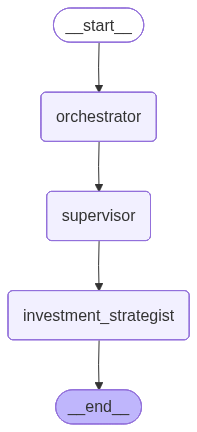

In [ ]:
graph